# Train an Azure Form Recognizer model and use it to analyze a document

> READ ME: If you haven't already tried Azure Form Recognizer, we enourage you to get started with [Try Azure Form Recognizer with the Python SDK](https://github.com/erikhopf/CognitiveServicesPyNotebooks/blob/main/Form_Recognizer.ipynb).

Out of the box, Azure Form Recgonizer can analyze, identify, and extract a bunch of data from your forms, receipts, invoices, and IDs with pretty high confidence. However, as you use Form Recognizer for more complex scenarios, or start to transcribe documents with specific terminology or custom layouts, you may need to create a custom model. 

Don't worry, Form Recognizer makes it easy to create a custom model. In this notebook, we'll show you how to create a custom model using existing documents. When you're finished, you should know how to create a model, use the model with Form Recognizer, and be able to determine if the model meets your needs. In the case that the model still needs some fine tuning, we have a few links that cover creating a custom model with data labels and how to label data in existing forms and documents.


## Before you get started

You'll need:

* An [Azure subscription](https://azure.microsoft.com/en-us/free/cognitive-services/)
* An [Azure Blob storage container](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-portal#create-a-container) to host your training data
* An [Azure Form Recognizer resource](https://ms.portal.azure.com/#create/Microsoft.CognitiveServicesFormRecognizer) in the Free (F0) or Standard (S0) pricing tier. Both will work for this notebook

## Install the Form Recognizer client library

Install the Form Recognizer client library to your environment. We strongly recommend that you run all of these notebooks in a virtual environment (virtualenv, venv, pyenv, pipenv, etc.). 

Run this command from your terminal/command line: `pip install azure-ai-formrecognizer --pre`.

## Data sources - IMPORTANT - DON'T SKIP THIS STEP!

To complete this tutorial you're going to need Azure Blob Storage. The Form Recognizer service can only build models from images/documents and associated JSON stored in an Azure Blob Storage container. 

1. Download the Form Recognizer training assets from GitHub    
   * [Training data](https://github.com/erikhopf/CognitiveServicesPyNotebooks/tree/main/sample_forms)
   * [Zip file](https://github.com/erikhopf/CognitiveServicesPyNotebooks/archive/refs/heads/main.zip) - Note, this is the repo zipped, which includes the notebooks
2. Create an [Azure Blob Storage container](https://docs.microsoft.com/en-us/azure/storage/blobs/storage-quickstart-blobs-portal)
3. Upload your training documents to the container. If you keep your container private, you'll need the SAS token appended to the URL when you call the service later. 
4. Generate a copy your SAS URL. You'll need this later.

### Create a storage account with the Azure portal

If you're new to the Azure portal it can be a bit confusing. Below you'll find images that walk you through the process of creating an Azure Blob storage container. For anyone familiar with the process, feel free to skip ahead to [Import modules](#import-modules).

1. Login to the Azure portal and select **Create resource**  
   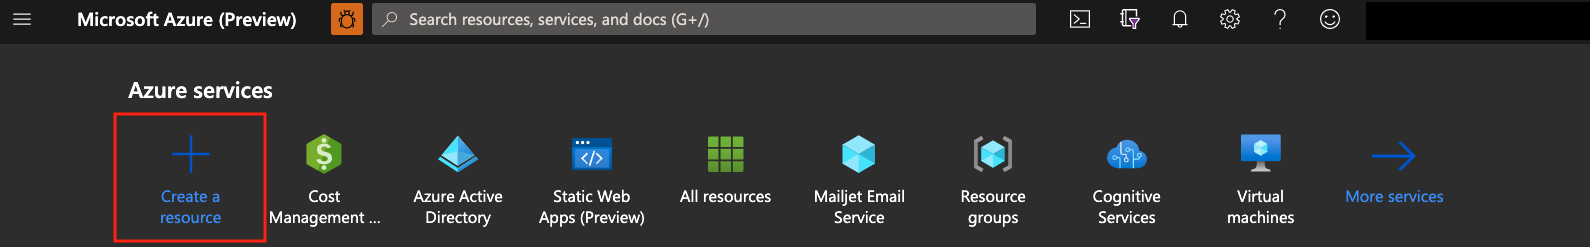
2. Type "Storage account" into the search bar, and select **Storage account**  
   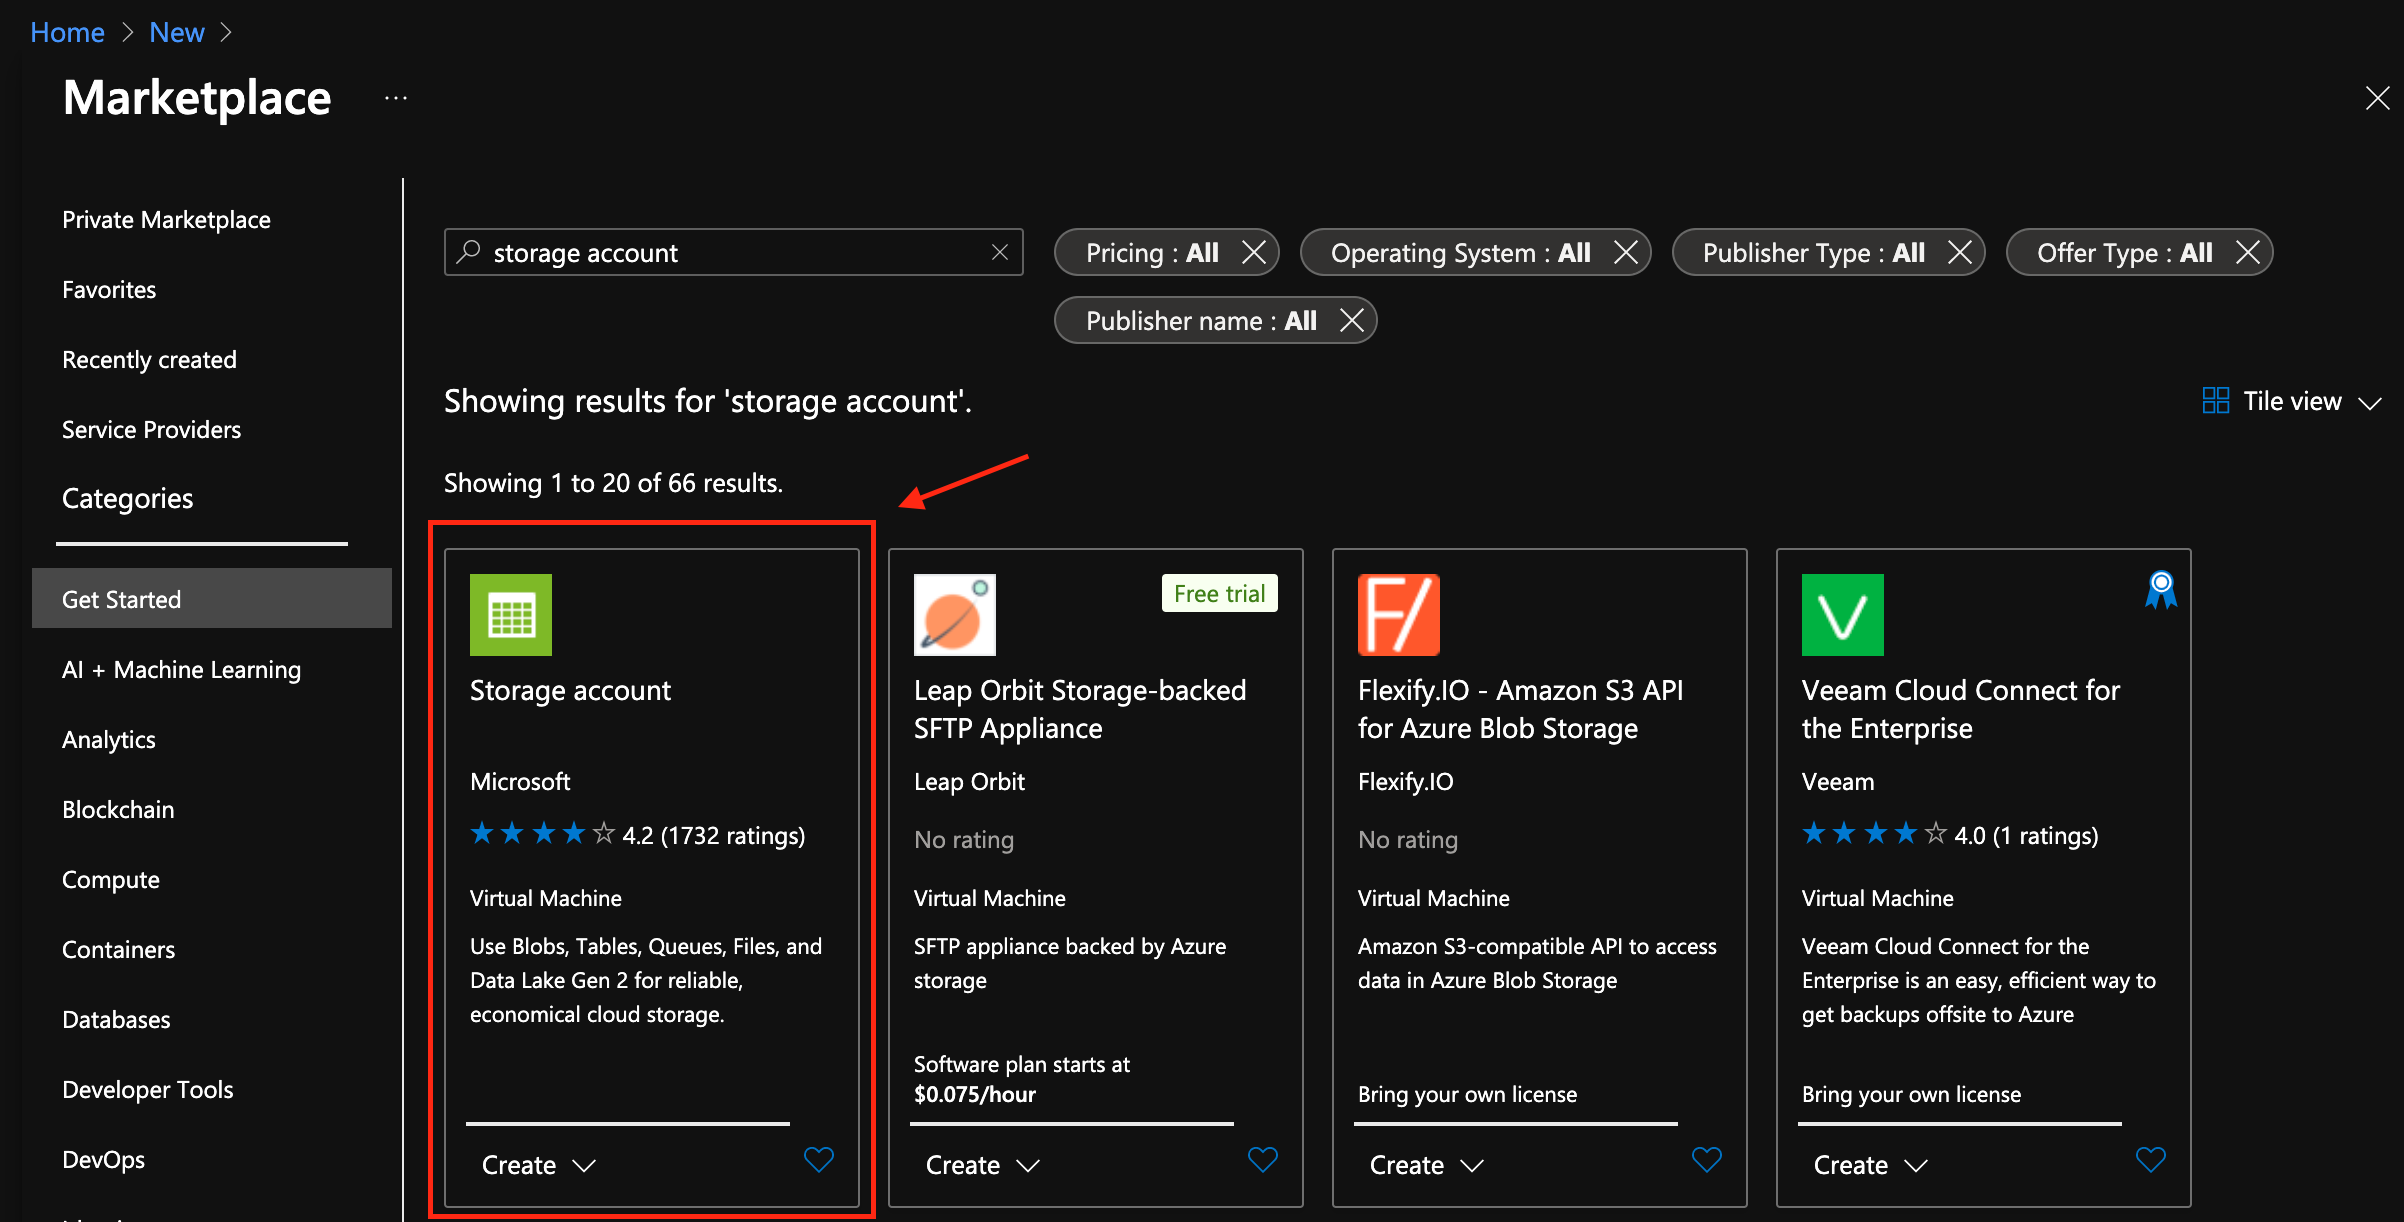
3. Locate and select **Containers**  
   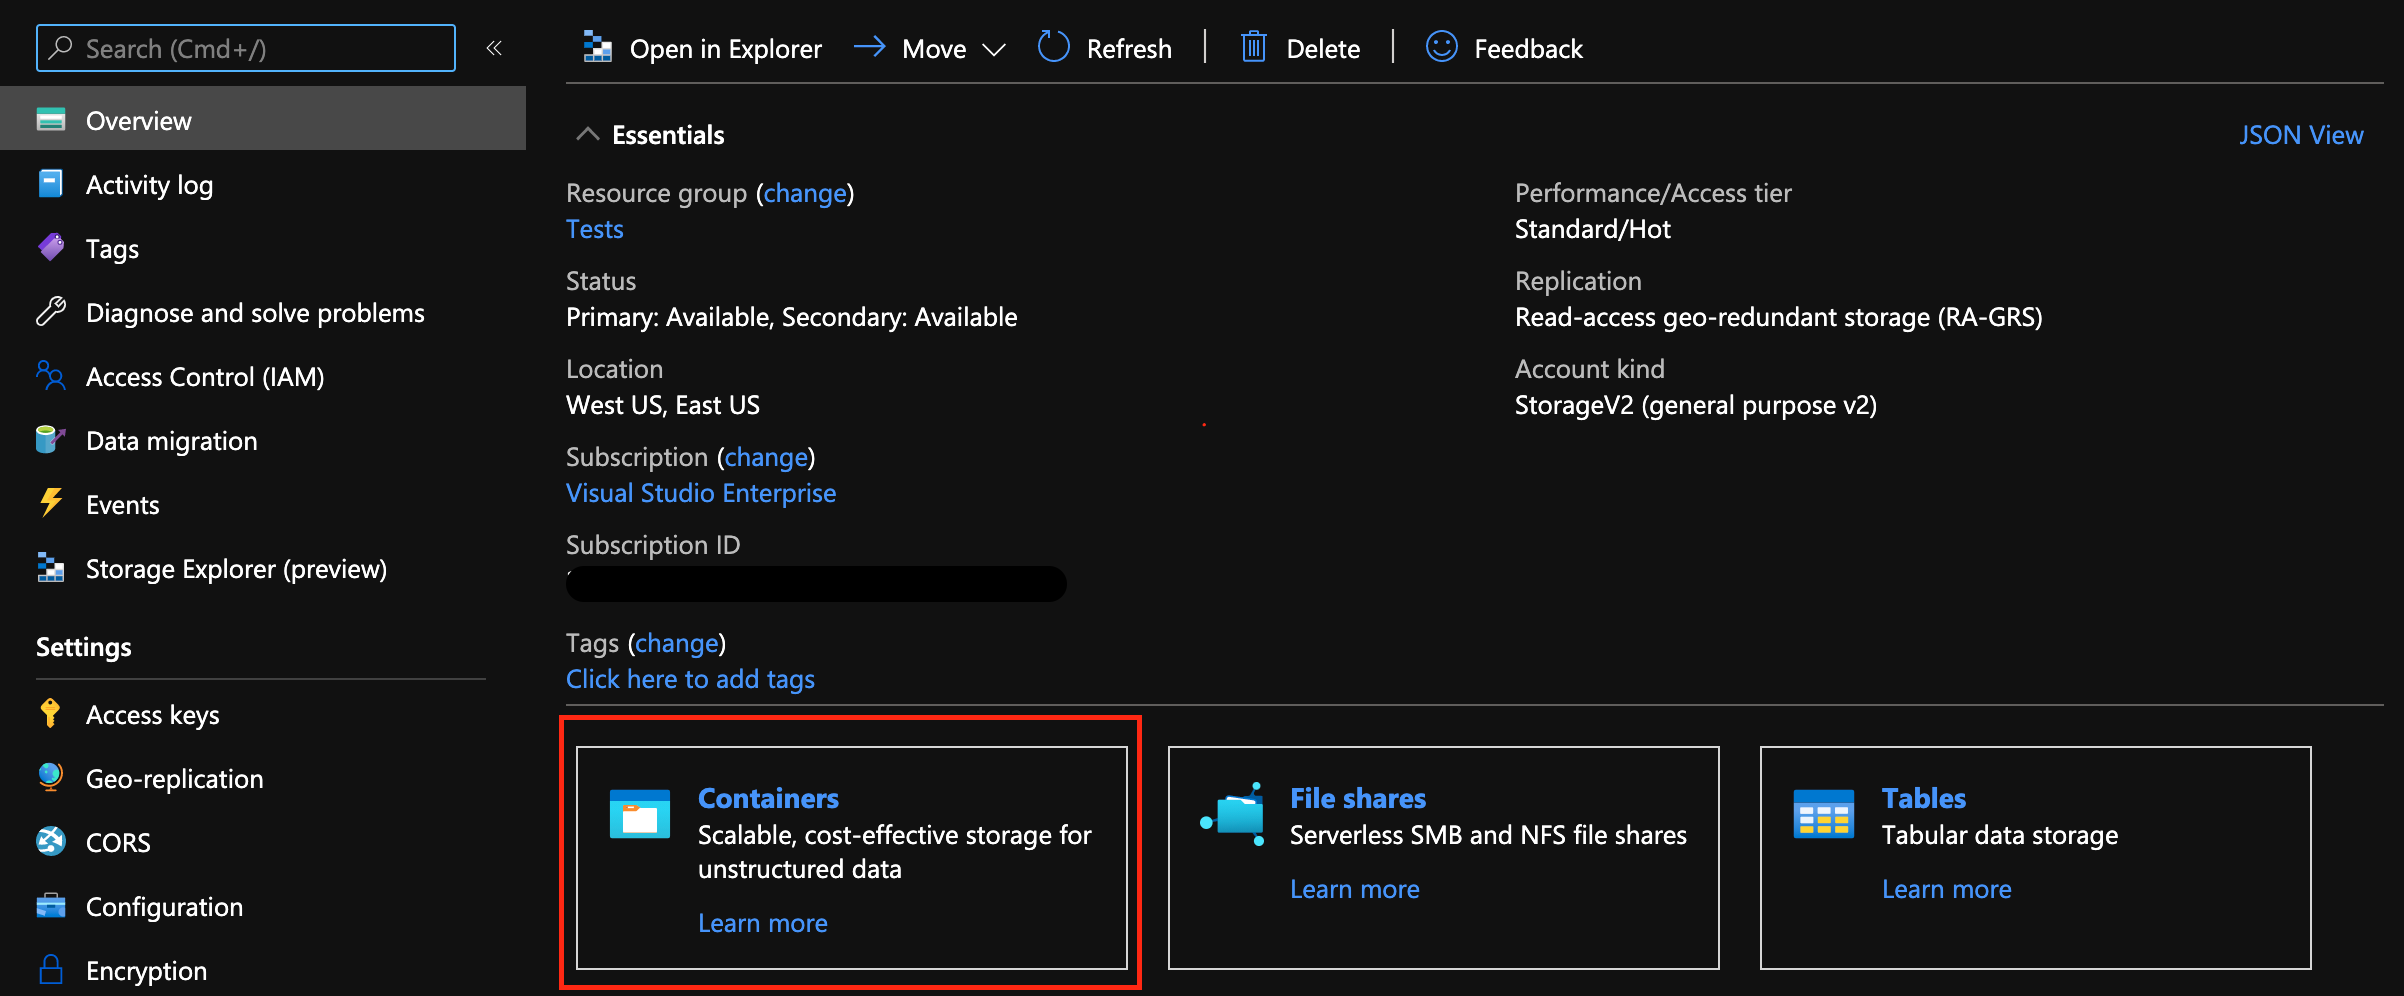
4. Add a container **+ Container**  
   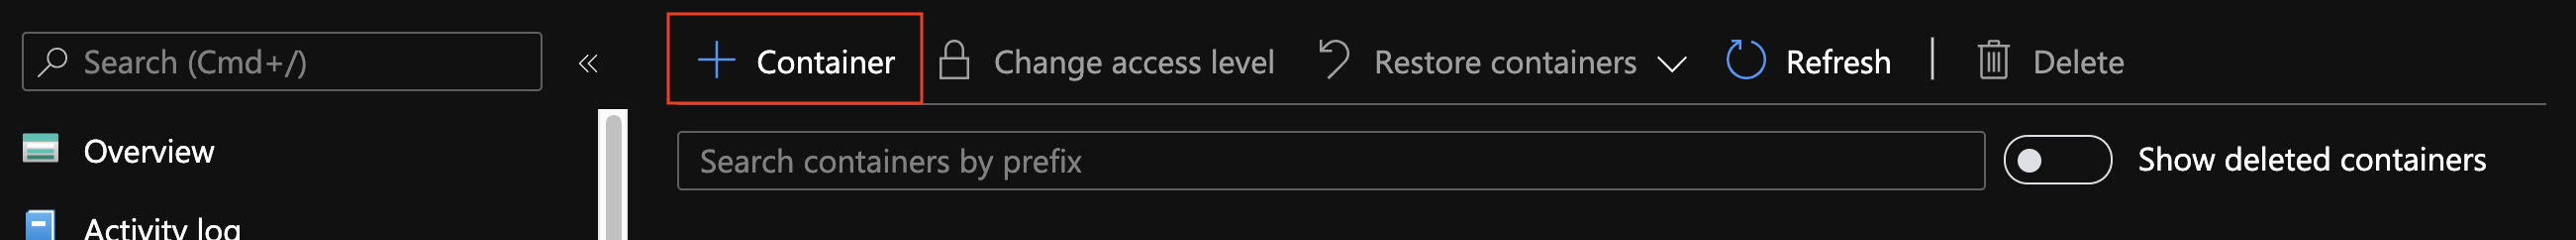
5. Name your container, set your permissions, then select **Create**  
   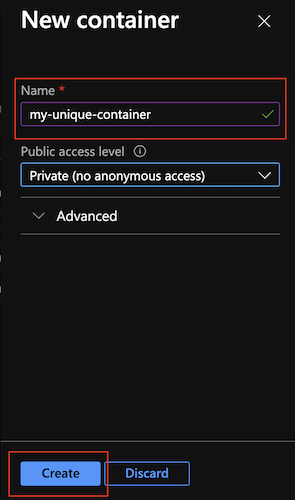
6. Upload the documents included in the zip file you downloaded earlier  
   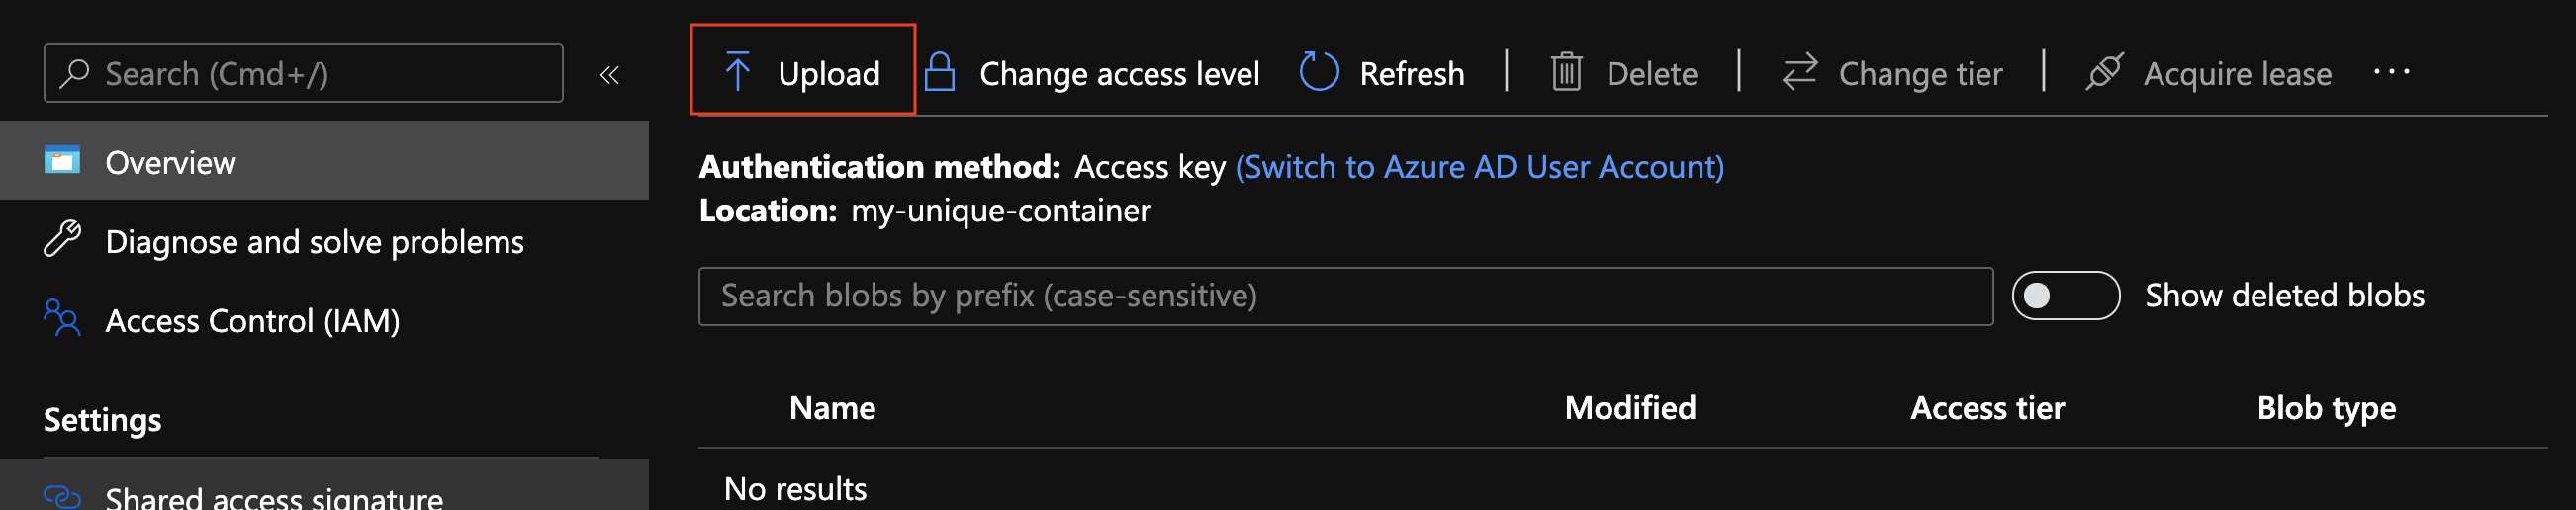
7. Generate an SAS URL and copy it to use later.  
   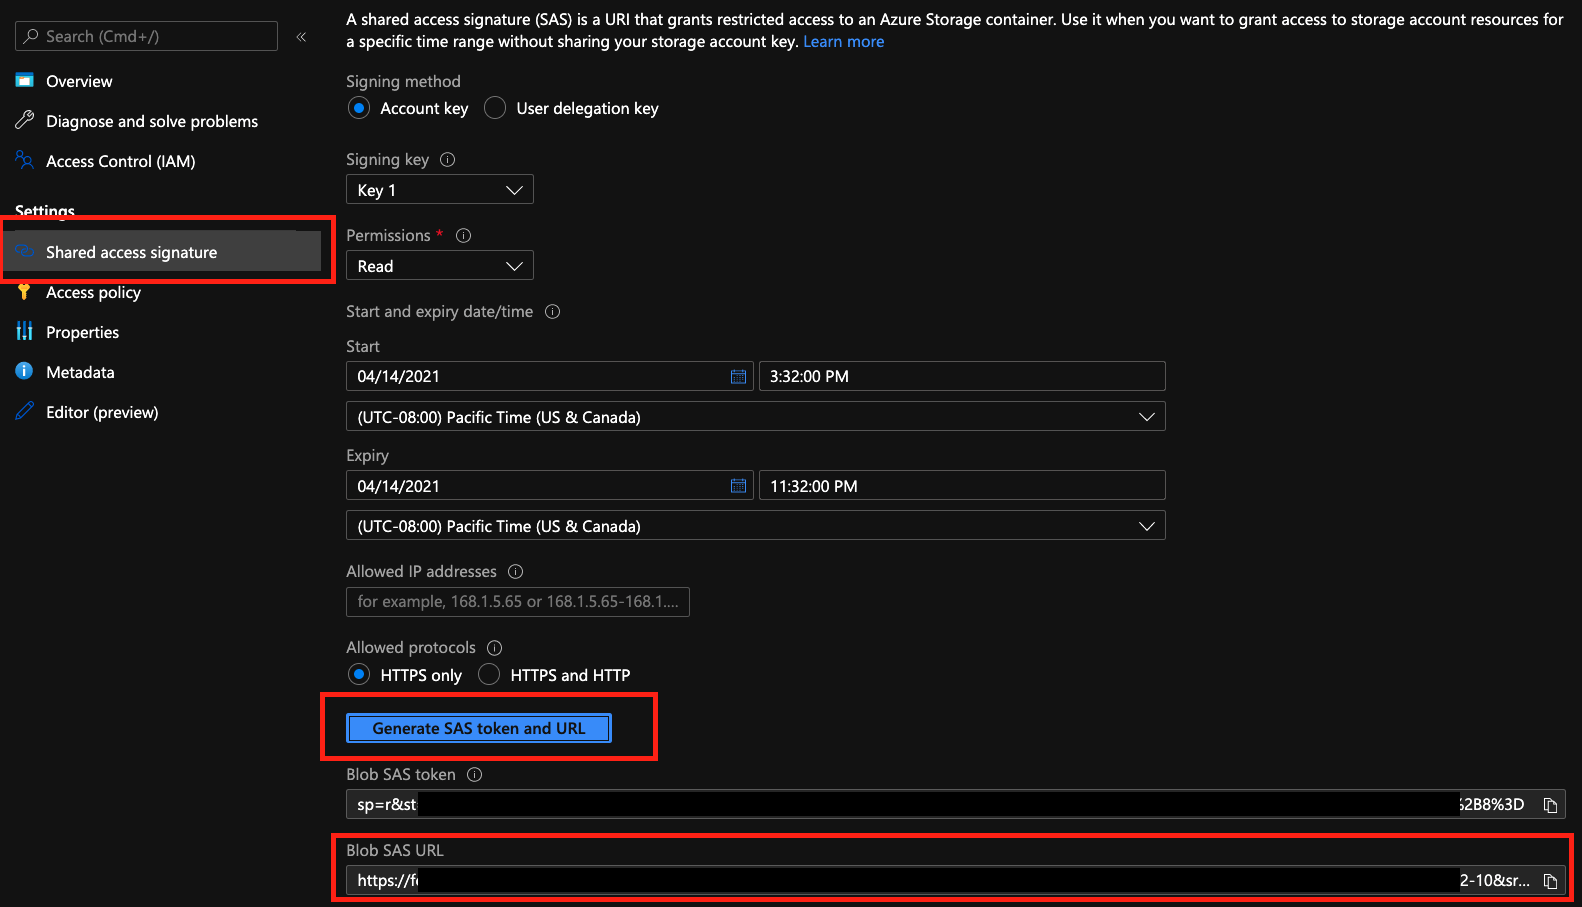

## Import modules

The first thing we need to do is import a few modules. Here's what they are and what you'll use them for:

1. `os` - This module is used to interact with the operating system using Python.
2. `azure.core.exceptions`
   * `ResourceNotFoundError` - An error response, typically triggered by a 412 response (for update) or 404 (for get/post).
3. `azure.ai.formrecognizer` - This module includes all Form Recognizer classes and components, like the `FormRecognizerClient` and `FormRecognizerTrainingClient`.
   * `FormRecognizerClient` - Used to create a Form Recognizer client which you'll use to interact with the service.
4. `azure.core.credentials` - This module is what's used to manage Azure credentials. Specificially, we are using `AzureKeyCredentials`.
   * `AzureKeyCredentials` - Provides the ability to update the key without creating a new client.

In [ ]:
import os
from azure.core.exceptions import ResourceNotFoundError
from azure.ai.formrecognizer import FormRecognizerClient
from azure.ai.formrecognizer import FormTrainingClient
from azure.core.credentials import AzureKeyCredential

Next, you're going to add the key and endpoint for your Form Recognizer resource from the Azure portal.

In [ ]:
endpoint = 'PASTE_YOUR_FORM_RECOGNIZER_ENDPOINT'
key = 'PASTE_YOUR_FORM_RECOGNIZER_KEY'

## Create and train a custom model

Here we're going to train a Form Recognizer model using the training data that you've downloaded from GitHub. 

Here's an outline of what you're going to do in this section:

* Create a Form Recognizer client. This is what you use to call the service, specifically to analyze documents and get the results. 
* Create a Training client. This is what you use to create, train and manage your custom models. 
* Update the `training_data_url` with the SAS URL you copied earlier. 
* Finally, you're going to execute the code blocks below to create your first custom model using sample form data. 

When finished, you'll get a print out with the model ID, the documents used to train the model and their status, and a list of recognized fields.

### Create your clients

In [ ]:
# Use this client to call the Form Recognizer service
form_recognizer_client = FormRecognizerClient(endpoint, AzureKeyCredential(key))

# Use this client to create and manage custom models
form_training_client = FormTrainingClient(endpoint, AzureKeyCredential(key))

### Train your model

**Before you continue**: Make sure that you update the code block with your Azure Blob Storage Container SAS URL before you run the sample.

There's one thing I'd like to call out below. The model that's being created **doesn't** use any label data and we are letting the training client know that we aren't supplying the label data JSON files with `use_training_labels=False`.

The last thing to call out, this code block will print a series of statements with information about the model, including: ID, status, document name, etc.

In [ ]:
# To train a model you need form data stored in an
# Azure Blob Storage account.

# Paste your SAS URL here. 
training_data_url = "PASTE_YOUR_AZURE_BLOB_STORAGE_SAS_URL"

poller = form_training_client.begin_training(training_data_url, use_training_labels=False)
model = poller.result()

# Information about the model you've created
print('\nModel information...')
print(f'Model ID: {model.model_id}')
print(f'Status: {model.status}')
print(f'Training started on: {model.training_started_on}')
print(f'Training completed on: {model.training_completed_on}')

# Training result information
# In this example you're looping over training_documents and printing
# name, status, page_count, and errors. 

print('\nDocuments used to build model...')
for doc in model.training_documents:
    print(f'Document name: {doc.name}')
    print(f'Document status: {doc.status}')
    print(f'Document page count: {doc.page_count}')
    print(f'Document errors: {doc.errors}')

# Recognized fields
# In this example you're looping over submodels, then looping over
# the dictionary in the submodel, printing the field.label when 
# available, otherwise printing the name.

print('\nRecognized fields...')
for submodel in model.submodels:
    print(f'The submodel with form type "{submodel.form_type}" has recognized the following fields:\n')
    for name, field in submodel.fields.items():
        print(f'{field.label if field.label else name}')

## Analyze a form with your custom model

Now it's time to call your model. Most of the code in this sample is in place to illustrate what type of infomration Form Recognizer extracts from the document, specifically field and table data. 

This sample relies on the first form in the training set. Feel free to try this with a different form in the training set or with a similar document. 

The last thing we'll call out is that the we're re-using the model ID from the previous section. You'll notice that when you call `begin_recognizer_custom_forms_from_url` that we've passed `model.model_id` in as a parameter. 

> Note: If you run this notebook multiple times, this code block will always use the last model created. To use a different model, update the `model_id=` param with your preferred model.

In [ ]:
# This test is using the first Form from the training data set that you downloaded
# earlier. Feel free to test this with any document in your training set, or with
# similar documents.
form_url = "https://raw.githubusercontent.com/Azure/azure-sdk-for-python/master/sdk/formrecognizer/azure-ai-formrecognizer/tests/sample_forms/forms/Form_1.jpg"

# In the previous section, you created a model. In this code block, you're
# passing in the model id as `model.model_id`.
poller = form_recognizer_client.begin_recognize_custom_forms_from_url(
    model_id=model.model_id, form_url=form_url)
result = poller.result()


# This block iterates over the result and primarily does two things:
# 1. Analyzes and prints the fields that Form Recognizer has identified
# 2. Identified and prints the table and table data identified in the document
for recognized_form in result:
    print(f'\n-----\nFields identified in "{recognized_form.form_type}"\n-----\n')
    for name, field in recognized_form.fields.items():
        print(f'Field: "{name}" | Label: "{field.label_data.text if field.label_data else name}"'
              f' | Value: "{field.value}" | Confidence score: "{field.confidence}"')
    for page in recognized_form.pages:
        table_count = 0
        if page.tables:
            print(f'\n-----\nTables identified in "{recognized_form.form_type}"\n-----')
            for table in page.tables:
                table_count += 1
                print(f'\nTABLE #{table_count}\n')
                for cell in table.cells:
                     print(f'Cell text: "{cell.text}" | Confidence score: "{cell.confidence}"')

## Review the output

So what do you think of the result? Not bad for training without any label data, right? You may notice that there is room for improvement or it might meet your standards. 

Things to keep in mind:
* You should train your model with at least 5 documents
* You can use additional documents to improve performance, however, if you find yourself using more than 30 documents to try and improve accuracy, it's probably time to look into providing label data along with the forms used to build your model. See [Next steps](#next-steps).

## How to manage custom models

With the training client, you can perform many model management tasks programatically. For example:
* Getting the total number of models you've created
* Listing models by their ID
* Getting details for a specific model
* Finally, how to delete a model

### Get a count of your models

Here you're calling the `get_account_properties()` operation, and specifically, we're going to extract a count of custom models that you've created. 

In [ ]:
account_properties = form_training_client.get_account_properties()
print(f'Our account has {account_properties.custom_model_count} custom models, '
      f'and we can have at most {account_properties.custom_model_limit} custom models.')

### List models for your Form Recognizer resource

This operation is particularly helpful. Here you're going to call `list_custom_models()` to print all available models associated with your Form Recognizer resource.

In [ ]:
# Next, we get a paged list of all of our custom models
custom_models = form_training_client.list_custom_models()

print("We have models with the following ids:")

# Let's pull out the first model
first_model = next(custom_models)
print(first_model.model_id)
for model in custom_models:
    print(model.model_id)

### List details about a specific model 

When you need to drill down on a specific model you can use the `get_custom_model()` operation, passing in a single `model_id`. This returns information about the model like when training was completed, the status, and more.

In [ ]:
# Note: This is using the model_id from the first model listed in the previous
# section of this notebook.
model_id = first_model.model_id

custom_model = form_training_client.get_custom_model(model_id=model_id)
print("Model ID: {}".format(custom_model.model_id))
print("Status: {}".format(custom_model.status))
print("Training started on: {}".format(custom_model.training_started_on))
print("Training completed on: {}".format(custom_model.training_completed_on))

### Delete a model

Running this will delete the first model listed by `list_custom_models()`.

In [ ]:
form_training_client.delete_model(model_id=custom_model.model_id)

try:
    form_training_client.get_custom_model(model_id=custom_model.model_id)
except ResourceNotFoundError:
    print("Successfully deleted model with id {}".format(custom_model.model_id))

## Reference

Alright, you've done a lot in about 10 mintes. If you want to learn more about the operations you're calling, we encourage you to view the Form Recognizer Python SDK reference.

* [Azure Form Recognizer Python SDK reference](https://docs.microsoft.com/python/api/overview/azure/ai-formrecognizer-readme?view=azure-python)

## Next steps

Now that you'ce learned how to create a custom model, the next step is to learn more about labeling form data and creating models that use label data. 

* [Learn how to use the label tool, a user interface driven experience](https://docs.microsoft.com/en-us/azure/cognitive-services/form-recognizer/quickstarts/label-tool?tabs=v2-1)
* [Learn more about customization on Microsoft Docs](https://docs.microsoft.com/en-us/azure/cognitive-services/form-recognizer/concept-custom)